# CIFAR100

In [1]:
# 导入
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

import math
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 数据探索

此处采用从Kaggle下载的CIFAR100数据集。

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
metadata_path = '.\data\CIFAR100\meta' 
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'fine_label_names'])))

In [4]:
pd.DataFrame(metadata[b'fine_label_names'])

,0
0,b'apple'
1,b'aquarium_fish'
2,b'baby'
3,b'bear'
4,b'beaver'
...,...
95,b'whale'
96,b'willow_tree'
97,b'wolf'
98,b'woman'


In [5]:
# 数据路径
data_pre_path = '.\data\CIFAR100\\' 

# 读取字典
data_train_dict = unpickle(data_pre_path + 'train')
data_test_dict = unpickle(data_pre_path + 'test')

# 读取数据
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'fine_labels'])

In [6]:
data_train.shape, data_test.shape

((50000, 3072), (10000, 3072))

In [7]:
# 转换数据
img_train = data_train.reshape(data_train.shape[0],3,32,32)

In [8]:
# 定义函数，将数据转换成RGB图片
def to_pil(data):
    r = Image.fromarray(data[0])
    g = Image.fromarray(data[1])
    b = Image.fromarray(data[2])
    pil_img = Image.merge('RGB', (r,g,b))
    return pil_img

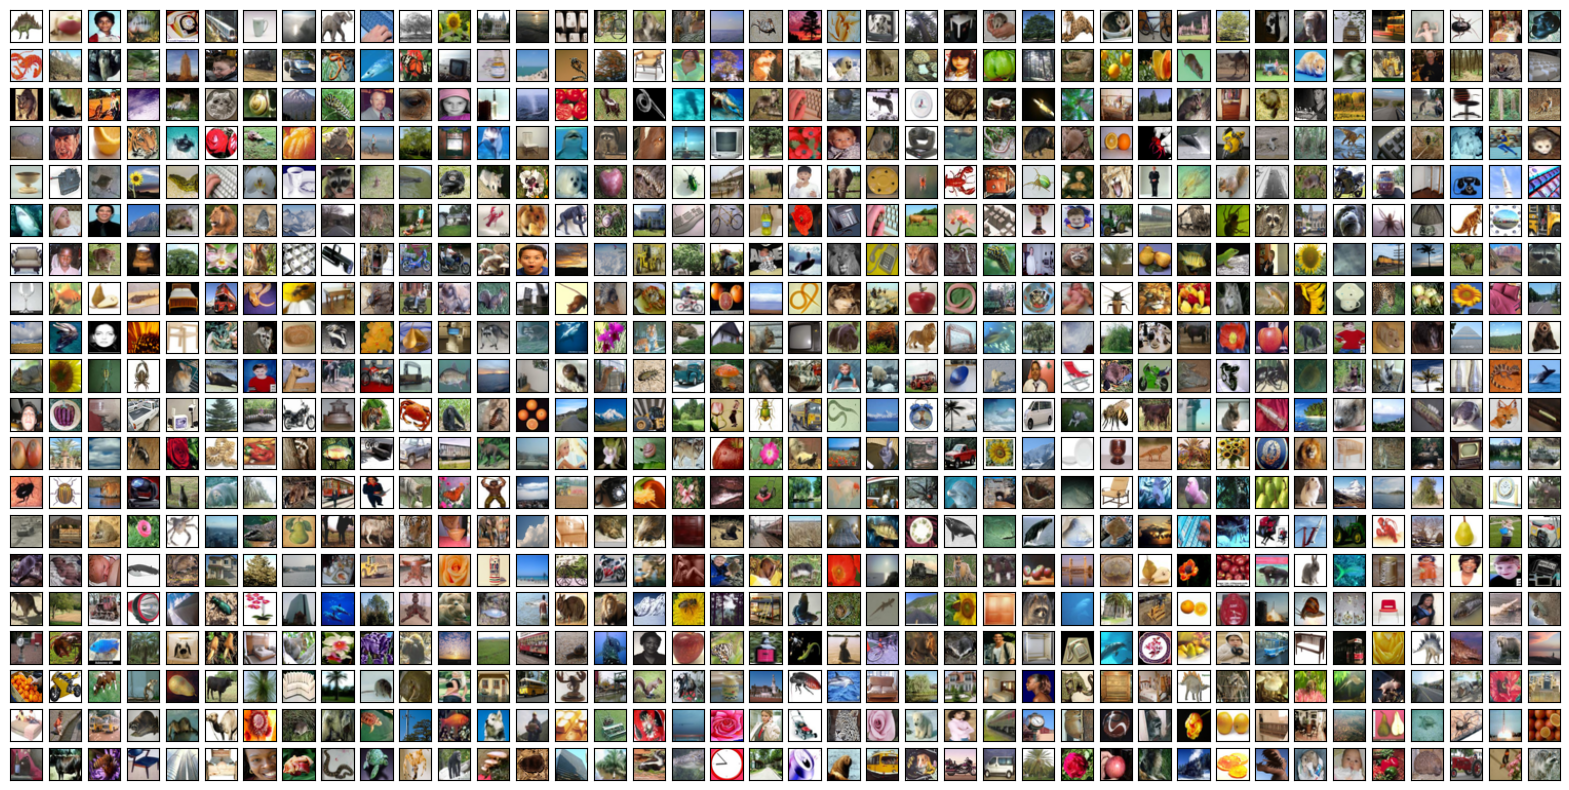

In [9]:
# 查看部分图像
fig, axes = plt.subplots(20, 40, figsize = (20,10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for i in range(1,801):
    
    img = to_pil(img_train[i])
    
    plt.subplot(20, 40, i)
    plt.imshow(img)

### GPU加速

- 确保GPU可用，用`torch.cuda.is_available()`查看
- 用`!nvidia-smi`监控GPU状态
- 确保网络和所有相关操作在GPU上执行
    - `net = Net().to(device)`确保模型在GPU上
    - `X.to(device)`, `y.to(device)`, 确保数据在GPU上
    - 确保其他与模型相关的操作（如自定义张量）也在GPU上执行


In [10]:
torch.__version__, torch.cuda.is_available()

('2.2.2+cu121', True)

In [11]:
# 查看GPU信息
!nvidia-smi

Thu Apr 25 16:35:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.10                 Driver Version: 532.10       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3               11W /  N/A|      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
# 定义设备
device = torch.device('cuda')

### 读取数据

以下直接从`torchvision.datasets`中获取CIFAR100数据集。

In [13]:
# 直接从torchvision.datasets中读取数据并转换
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### 网络结构

In [14]:
# 定义网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### 训练

In [15]:
# 初始化网络
net = Net().to(device) # 确保模型在GPU上
criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = optim.Adam(net.parameters(), lr=0.001) # Adam算法
scheduler = StepLR(optimizer, step_size=25, gamma=0.1) # 学习率调度器，在每 25 个 epoch 减少学习率


In [16]:
# 训练并输出训练过程

num_epochs = 100  # 迭代次数

train_losses, train_accuracies, valid_accuracies = [], [], []  # 初始化列表：损失、准确率

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    net.train()  # 确保模型在训练模式
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)  # 确保数据在GPU上
        
        optimizer.zero_grad() # 清空梯度

        outputs = net(inputs) # 前向传播
        loss = criterion(outputs, labels) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数

        running_loss += loss.item()           
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()  # 更新学习率

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct_train / total_train)

    # 验证集准确率
    correct_valid = 0
    total_valid = 0
    net.eval() # 确保模型在评估模式
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # 确保数据在GPU上
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
    valid_accuracies.append(100 * correct_valid / total_valid)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Valid Acc: {valid_accuracies[-1]:.2f}')


Epoch 1/100, Train Loss: 3.9849, Train Acc: 8.38, Valid Acc: 14.05
Epoch 2/100, Train Loss: 3.5435, Train Acc: 15.27, Valid Acc: 19.96
Epoch 3/100, Train Loss: 3.3271, Train Acc: 19.09, Valid Acc: 24.28
Epoch 4/100, Train Loss: 3.1836, Train Acc: 21.79, Valid Acc: 26.22
Epoch 5/100, Train Loss: 3.0730, Train Acc: 23.59, Valid Acc: 28.61
Epoch 6/100, Train Loss: 2.9801, Train Acc: 25.51, Valid Acc: 31.00
Epoch 7/100, Train Loss: 2.9072, Train Acc: 26.77, Valid Acc: 31.86
Epoch 8/100, Train Loss: 2.8484, Train Acc: 28.16, Valid Acc: 33.09
Epoch 9/100, Train Loss: 2.7926, Train Acc: 29.13, Valid Acc: 34.37
Epoch 10/100, Train Loss: 2.7556, Train Acc: 29.63, Valid Acc: 34.95
Epoch 11/100, Train Loss: 2.7117, Train Acc: 30.95, Valid Acc: 34.55
Epoch 12/100, Train Loss: 2.6951, Train Acc: 30.88, Valid Acc: 36.39
Epoch 13/100, Train Loss: 2.6631, Train Acc: 31.47, Valid Acc: 36.37
Epoch 14/100, Train Loss: 2.6348, Train Acc: 32.09, Valid Acc: 37.42
Epoch 15/100, Train Loss: 2.6127, Train Acc:

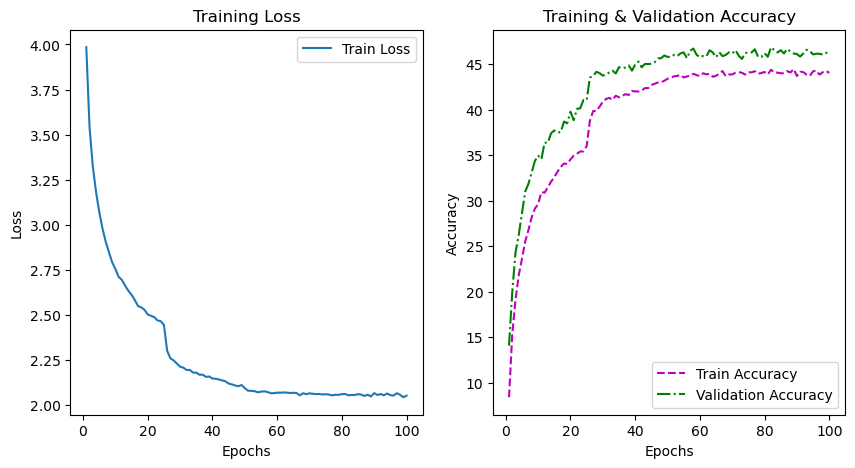

In [17]:
# 绘制损失和精度图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, 'm--', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracies, 'g-.', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# 保存模型参数
torch.save(net.state_dict(), 'model_weights.pth')

# 读取模型参数
# net = Net()  # 重新创建模型实例，Net是模型类
# net.load_state_dict(torch.load('model_weights.pth'))

In [19]:
# 保存训练指标
with open('train_history.pkl', 'wb') as f:
    pickle.dump({'train_loss': train_losses, 'train_acc': train_accuracies, 'valid_acc': valid_accuracies}, f)

# 读取训练指标
# with open('train_history.pkl', 'rb') as f:
#     history = pickle.load(f)

In [20]:
# 用混淆矩阵评估模型

# 模型设为评估模式
net.eval()

# 存储所有真实标签和预测标签
all_preds = []
all_labels = []

# 不计算梯度，因为在评估模式下不需要反向传播
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)  # # 确保数据在GPU上
        outputs = net(images)
        
        # 获取预测结果的最大值（概率）
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)


In [21]:
# 打印每个类别被正确分类的个数
np.diagonal(cm)

array([77, 59, 36, 23, 29, 47, 50, 45, 55, 55, 29, 19, 51, 34, 33, 28, 47,
       68, 43, 38, 71, 67, 30, 75, 72, 31, 33, 40, 63, 38, 42, 51, 32, 48,
       35, 25, 50, 41, 31, 55, 28, 68, 49, 52, 21, 29, 29, 49, 78, 66, 23,
       41, 73, 84, 66, 12, 62, 49, 52, 35, 81, 49, 59, 37, 25, 24, 32, 43,
       79, 64, 49, 70, 17, 42, 31, 63, 71, 24, 23, 41, 20, 50, 86, 36, 37,
       60, 47, 56, 47, 59, 36, 57, 28, 24, 84, 50, 41, 53, 13, 46],
      dtype=int64)

In [22]:
# 打印模型分类报告
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.72      0.77      0.74       100
           1       0.49      0.59      0.53       100
           2       0.30      0.36      0.33       100
           3       0.31      0.23      0.26       100
           4       0.25      0.29      0.27       100
           5       0.34      0.47      0.39       100
           6       0.48      0.50      0.49       100
           7       0.51      0.45      0.48       100
           8       0.57      0.55      0.56       100
           9       0.64      0.55      0.59       100
          10       0.45      0.29      0.35       100
          11       0.39      0.19      0.26       100
          12       0.53      0.51      0.52       100
          13       0.42      0.34      0.38       100
          14       0.43      0.33      0.37       100
          15       0.35      0.28      0.31       100
          16       0.55      0.47      0.51       100
          17       0.57    

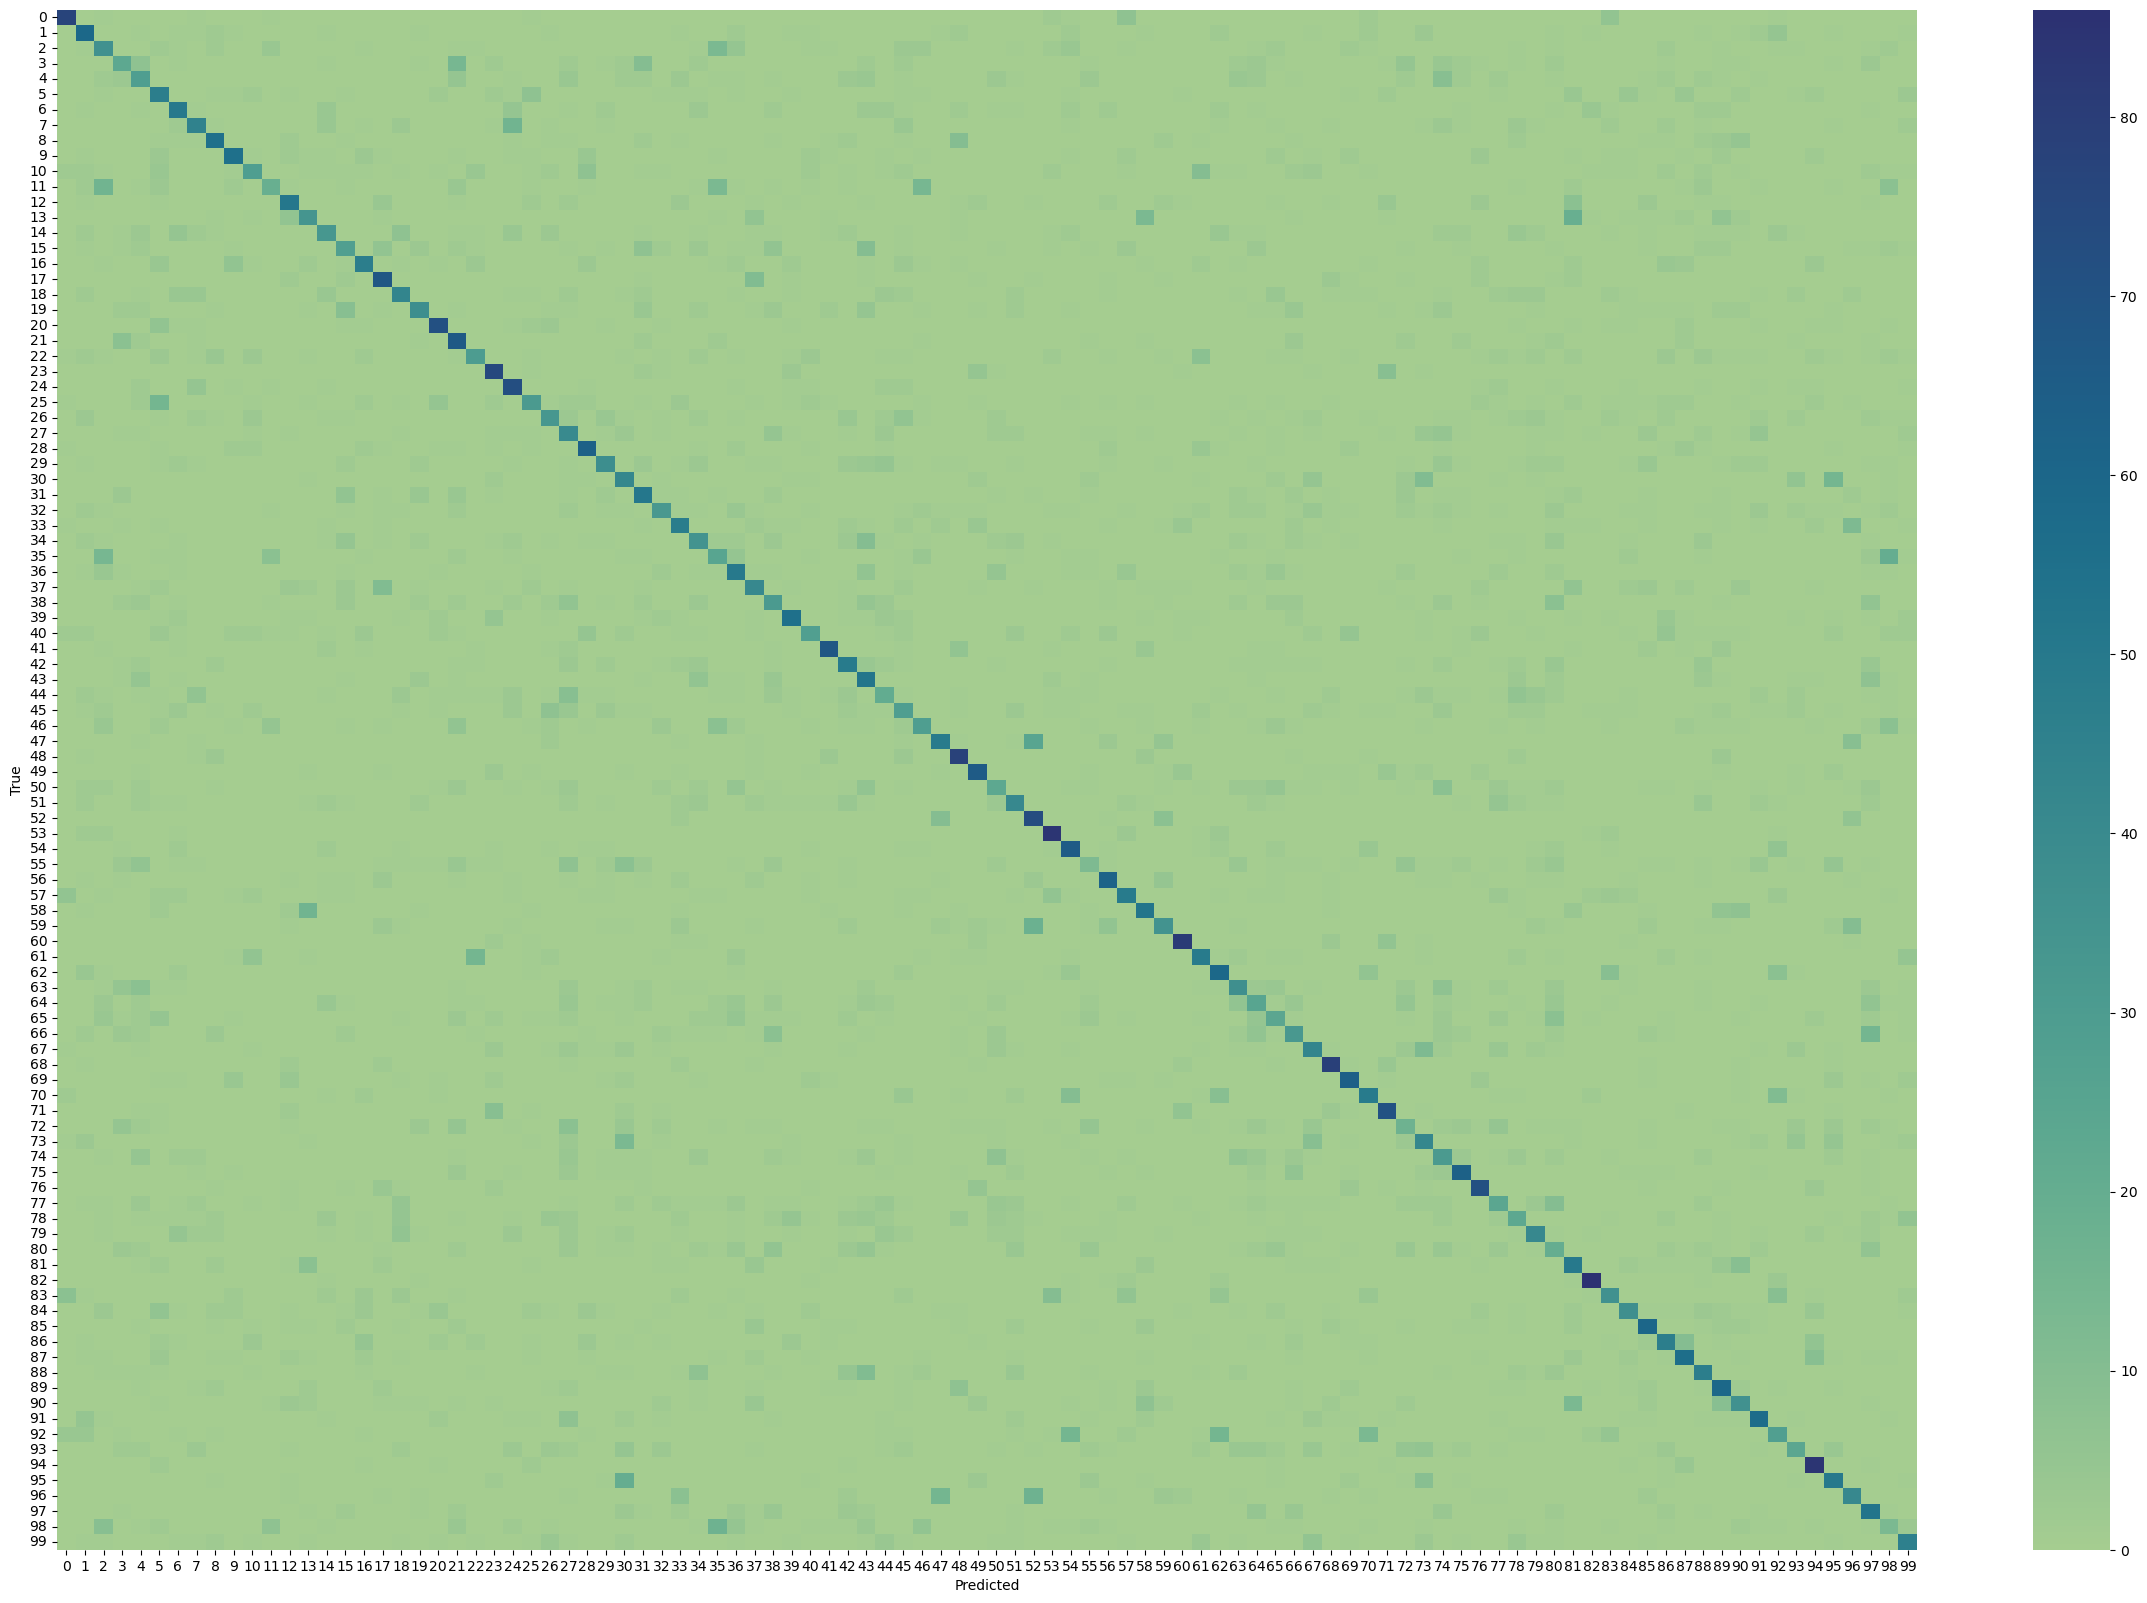

In [23]:
# 绘制混淆矩阵
plt.figure(figsize=(30,20))
sns.heatmap(cm, cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()